# LSTMx4 st12_9_temp +3 LB = 0.95

### Import libs

In [1]:
# Путь расположения файлов, если меняется, то заменить
# Папка с исходными файлами 'X_test.npy', 'X_train.npy', 'y_train.csv', 'sample_submission.csv'
#PATH = '/content/drive/MyDrive/Motorica/'

In [2]:
# Поключение google drive для для чтения файлов
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
import os
PATH = ""

#print(os.listdir(PATH))

# Папка для сохранения моделей и файлов
PATH_BEST_MODEL = os.path.join(PATH, 'best_models/')

# Импорты необходимых библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
# библиотека вызова функций
import Motorica_2 as m

## Преобразование данных с помощью скользящего среднеквадратического отклонения

Для преобразования y_train на основании сигналов датчиков с

In [4]:
import __init__
X_train = __init__.X_train
y_train = __init__.y_train

y_train_ch = []
for id in range(X_train.shape[0]):
    
    df0_T = pd.DataFrame(data=X_train[id], 
                         index=range(X_train.shape[1]), 
                         columns=range(X_train.shape[2])).T
    y_k = y_train[id*100:(id+1)*100].reset_index().T.loc['class'].values
    
    # будем изменять только те наблюдения y_train, в которых происходит изменение жеста
    if np.sum(y_k)!=0: 
    # строим скользящее STD
        time_stp = 0
        time_end = 100
        df_T_stp = df0_T.iloc[time_stp:time_end]
        df_T_stp_std_1 = df_T_stp.rolling(window=5).std().dropna(axis=0)
        
        # выбираем активные датчики
        strong_sens_list = m.get_sensor_list(id) 

        # рассчитываем начало времени выполнения жеста, исходя из медианного значения скользящего std, 
        # для которого превышен порог 15 по каждому активному датчику, 
        # с последующим выбором медианы из полученного списка 
        grow_ind = int(
            np.median([np.median(np.nonzero((df_T_stp_std_1[x]>15).values)[0]) \
                       for x in strong_sens_list \
                       if np.any(np.nonzero((df_T_stp_std_1[x]>15).values)[0])])) + 3

        # преобразование строки y_train:
        y_k_ch = np.empty(100)
        y_k_ch[:grow_ind].fill(y_k[0]) # до grow_ind - заполняем первым значением k-го наблюдения из y_train
        y_k_ch[grow_ind:].fill(y_k[-1]) # после grow_ind - последним значением k-го наблюдения из y_train
        y_train_ch.append(y_k_ch)
    
    else:
        y_k_ch = np.zeros(100)
        y_train_ch.append(y_k_ch)

y_train_ch = np.array(y_train_ch)
print(y_train_ch.shape)

(323, 100)


Посмотрим, что получилось после преобразования:

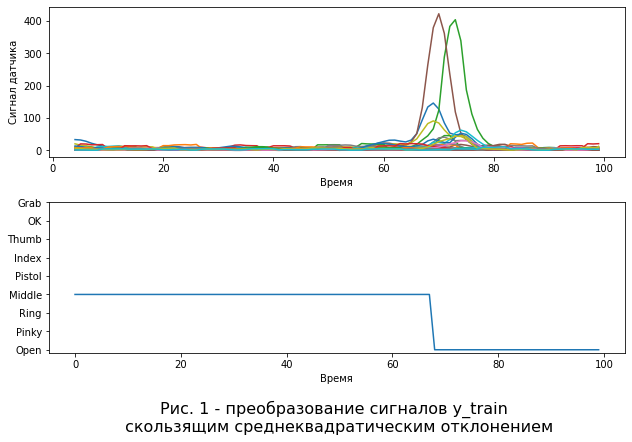

In [5]:
# Наблюдение 7
id=7 

plot_counter = 1

df0_T = pd.DataFrame(data=X_train[id], 
                         index=range(X_train.shape[1]), 
                         columns=range(X_train.shape[2])).T
df_T_stp = df0_T
df_T_stp_std_1 = df_T_stp.rolling(window=5).std().dropna(axis=0)


fig, ax = plt.subplots(2, 1, figsize=(10,6)) #sharex=True

plt.subplots_adjust(  left=0.1,   right=0.9,
                    bottom=0.1,     top=0.9,
                    wspace=0.1,  hspace=0.3)

plt.suptitle(f'Рис. {plot_counter}'+' - преобразование сигналов y_train \n скользящим среднеквадратическим отклонением', y=-0.01, fontsize=16)

ax[0].plot(pd.DataFrame(df_T_stp_std_1))
ax[0].set_ylabel('Сигнал датчика')
ax[0].set_xlabel('Время')

ax[1].plot(y_train_ch[id])
ax[1].set_yticks(
                  np.arange(9),
                  ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
ax[1].set_xlabel('Время')
    
plt.show()

In [6]:
# # Можно пробежаться по всем 323 наблюдениям X_train и измененного y_train для визуального анализа преобразований
# for i in range(X_train.shape[0]):
#     fig, axx = plt.subplots(2, 1, figsize=(10,6), sharex=True)
#     axx[0].plot(pd.DataFrame(X_train[i].T))
#     axx[0].legend()
#     axx[1].plot(y_train_ch[i])
#     axx[1].set_yticks(
#         np.arange(9),
#         ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
#     )
#     plt.suptitle(f'Train {i}')
#     plt.show()

Данные для подачи в модель подготовлены, перейдем к построению модели.   
Для начала рассмотрим Baseline, предложенный организаторами соревнования.


## NN Baseline

### Model architecture baseline

In [7]:
import __init__
X_train = __init__.X_train
X_test = __init__.X_test
y_train = __init__.y_train

#y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
y_train = y_train.pivot(index='sample', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

X_train_nn = X_train.swapaxes(1, 2)
X_test_nn = X_test.swapaxes(1, 2)
y_train_nn = tf.keras.utils.to_categorical(y_train)

print(X_train_nn.shape, y_train_nn.shape)
print(X_test_nn.shape)

(323, 100, 40) (323, 100, 9)
(54, 100, 40)


In [8]:
tf.keras.backend.clear_session()

input_channels = x = tf.keras.layers.Input(
    (X_train.shape[2], X_train.shape[1]),
)
x = tf.keras.layers.SimpleRNN(
    units=X_train.shape[2],
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
x = tf.keras.layers.SimpleRNN(
    units=X_train.shape[2],
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
output = tf.keras.layers.Dense(units=9, activation='sigmoid')(x) 

model_baseline = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model_baseline.compile(
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
    optimizer=tf.keras.optimizers.Adam(), # learning_rate=1e-2
)
model_baseline.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 40)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 100)          14100     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 100)          20100     
                                                                 
 dense (Dense)               (None, 100, 9)            909       
                                                                 
Total params: 35,109
Trainable params: 35,109
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model_baseline.fit(
    X_train_nn,
    y_train_nn, 
    epochs=200,
    verbose=1
)

Epoch 1/200
11/11 [==============================] - 2s 25ms/step - loss: 17.4674 - accuracy: 0.4064
Epoch 2/200
11/11 [==============================] - 0s 25ms/step - loss: 15.2933 - accuracy: 0.5556
Epoch 3/200
11/11 [==============================] - 0s 25ms/step - loss: 13.4845 - accuracy: 0.5813
Epoch 4/200
11/11 [==============================] - 0s 24ms/step - loss: 11.8728 - accuracy: 0.6408
Epoch 5/200
11/11 [==============================] - 0s 24ms/step - loss: 10.4075 - accuracy: 0.6733
Epoch 6/200
11/11 [==============================] - 0s 25ms/step - loss: 9.1234 - accuracy: 0.6725
Epoch 7/200
11/11 [==============================] - 0s 25ms/step - loss: 7.9959 - accuracy: 0.6818
Epoch 8/200
11/11 [==============================] - 0s 24ms/step - loss: 6.9536 - accuracy: 0.7000
Epoch 9/200
11/11 [==============================] - 0s 25ms/step - loss: 6.0492 - accuracy: 0.6937
Epoch 10/200
11/11 [==============================] - 0s 24ms/step - loss: 5.2419 - accuracy: 0

### Visualisation

In [10]:
y_pred_train_nn = model_baseline.predict(X_train_nn)
y_pred_train_nn.shape

11/11 [==============================] - 0s 9ms/step


(323, 100, 9)

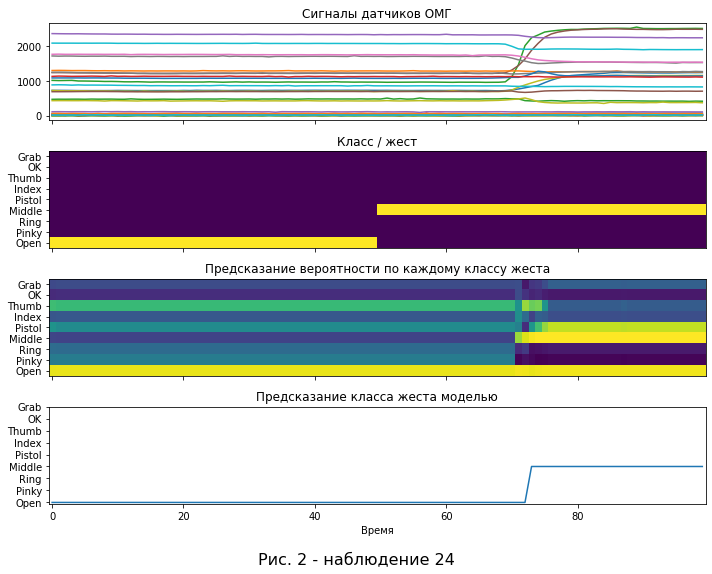

In [11]:
plot_counter = 2 # номер рисунка

id = 24

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

plt.subplots_adjust(  left=0.1,   right=0.9,
                    bottom=0.1,     top=0.9,
                    wspace=0.1,  hspace=0.3)

ax[0].plot(X_train[id].T)
ax[0].set_title('Сигналы датчиков ОМГ')

ax[1].imshow(y_train_nn[id].T, origin="lower")
ax[1].set_aspect('auto')
ax[1].set_title('Класс / жест')
ax[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

ax[2].imshow(y_pred_train_nn[id].T, origin="lower") # , vmin=-0.5, vmax=0.5
ax[2].set_aspect('auto')
ax[2].set_title('Предсказание вероятности по каждому классу жеста')
ax[2].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

ax[3].plot(y_pred_train_nn[id].argmax(axis=-1))
ax[3].set_aspect('auto')
ax[3].set_title('Предсказание класса жеста моделью')
ax[3].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
ax[3].set_xlabel('Время')

plt.suptitle(f'Рис. {plot_counter}'+' - наблюдение ' + str(id), y=-0.01, fontsize=16)

plt.tight_layout()

plt.gcf()


    
plt.show()


### Интерпретация графиков

График 1 - это данные зафиксированные оптомиографическими датчиками. График 2 подача команды на совершение жеста для пилота. Как можно видеть есть некоторый временной лаг, объясняемый временем реакции.

График 3 - это предсказания модели. График 4 - это фактическое движение, на тестовых данных именно оно будет использоваться для скоринга.

### Model predict

In [12]:
y_pred_nn = model_baseline.predict(X_test_nn).argmax(axis=-1)

print(y_pred_nn.shape)
y_pred_nn

2/2 [==============================] - 0s 8ms/step
(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [13]:
y_pred = np.concatenate([arr for arr in y_pred_nn])

print(y_pred.shape)
y_pred

(5400,)


array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [14]:
y_test = pd.read_csv(os.path.join(PATH, './sample_submission.csv'))
y_test['class'] = y_pred
y_test.to_csv('./y_test_2rnn_sigmoid_predicted.csv', index=False)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
...,...,...
5396,376-96,4
5397,376-97,4
5398,376-98,4
5399,376-99,4


In [15]:
y_test['class'].value_counts()

0    3544
5     493
2     296
3     274
8     255
1     192
6     147
4     126
7      73
Name: class, dtype: int64

## Model LSTM

In [16]:
# Подготовка данных для подачи в модель
X_train_nn = X_train.swapaxes(1, 2)
X_test_nn = X_test.swapaxes(1, 2)
y_train_nn = tf.keras.utils.to_categorical(y_train_ch)

print(X_train_nn.shape, y_train_nn.shape)
print(X_test_nn.shape)

(323, 100, 40) (323, 100, 9)
(54, 100, 40)


In [17]:
# Функция для расчета метрики f1_score 
# Примечание: Metrics have been removed from Keras core on 2.0 version
# https://stackoverflow.com/questions/66554207/calculating-micro-f-1-score-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """
        Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

В baseline было предложено использовать нейронную сеть с двумя слоями SimpleRNN,  На baseline, как и ожидалось был получен довольно низкий скор по метрике f1.  
Для получения лучшего скора и предсказания модели на тестовых данных была собрана модель из 4-х последовательных слоев LSTM (встроенные в Keras слои рекуррентной нейронной сети, предназначенной для предсказания данных временных рядов), одного полносвязанного слоя с функцией активации 'relu' и выходного слоя с функцией активации 'softmax' (для многоклассовой классификации). В качестве loss-функции выбрана "categorical_crossentropy" и optimizer='Adam'. Между выходным и полносвязным слоями добавлены слои BatchNormalization (для ускорения обучения модели и лучшей стабильности) и Dropout (для исключения переобучения).  
При обучении использовались callbacks: для сохранения лучшего результата, постепенного уменьшения learning rate (если не растет f1-score) и остановки обучения в случае длительного отсутствия улучшения рассматриваемой метрики.

In [18]:
# удаляем предыдущую модель (если был подбор гиперпараметров) и очищаем память
tf.keras.backend.clear_session()

# входной слой
input_channels = x = tf.keras.layers.Input(
    (X_train.shape[2], X_train.shape[1]),
)

x = tf.keras.layers.BatchNormalization()(x) # добавили новый слой из baseline - нормализация 
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x) 
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x)  
x = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)(x)  
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)


output = tf.keras.layers.Dense(units=9, activation='softmax')(x) #activation=tf.keras.layers.Softmax(axis=-1)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.compile(
    loss="categorical_crossentropy",
    metrics=[f1],
    optimizer=tf.keras.optimizers.Adam(), # learning_rate=1e-2
)
model.summary()

# Callbacks that used for training model
def callbacks(lr):
    checkpoint = ModelCheckpoint(PATH_BEST_MODEL+'best_model.hdf5', monitor='val_f1', 
                                 verbose=1, mode='max', save_best_only=True)
    earlystop = EarlyStopping(monitor='val_f1', mode='max', patience=300, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_f1', mode='max', factor=0.9, patience=10, verbose=1, 
                                  min_lr=lr/10000)
    return [checkpoint, earlystop, reduce_lr]

callbacks_list = callbacks(lr=0.001)

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 40)     160         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 lstm (LSTM)                    [(None, 100, 100),   56400       ['batch_normalization[0][0]']    
                                 (None, 100),                                                     
                                 (None, 100)]                                                 

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Model train

In [20]:
# Обучение модели
history = model.fit(
    X_train_nn,
    y_train_nn, 
    validation_split = 0.10, # доля обучающей выборки, которая идёт на валидацию
    epochs=1500,
    verbose=1,
    callbacks = callbacks_list
)

Epoch 1/1500
10/10 [==============================] - ETA: 0s - loss: 1.5856 - f1: 0.4994
Epoch 1: val_f1 improved from -inf to 0.00000, saving model to best_models\best_model.hdf5
10/10 [==============================] - 9s 389ms/step - loss: 1.5856 - f1: 0.4994 - val_loss: 2.1426 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/1500
10/10 [==============================] - ETA: 0s - loss: 0.8134 - f1: 0.7931
Epoch 2: val_f1 did not improve from 0.00000
10/10 [==============================] - 2s 223ms/step - loss: 0.8134 - f1: 0.7931 - val_loss: 2.0429 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 3/1500
10/10 [==============================] - ETA: 0s - loss: 0.5621 - f1: 0.8519
Epoch 3: val_f1 did not improve from 0.00000
10/10 [==============================] - 2s 228ms/step - loss: 0.5621 - f1: 0.8519 - val_loss: 2.0754 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 4/1500
10/10 [==============================] - ETA: 0s - loss: 0.4093 - f1: 0.8844
Epoch 4: val_f1 did not improve from 0.00000
10/10 

In [38]:
history.history.keys()

dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])

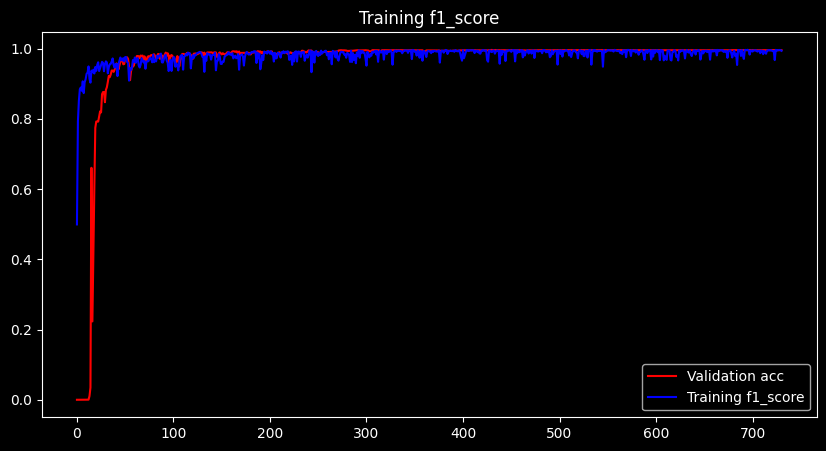

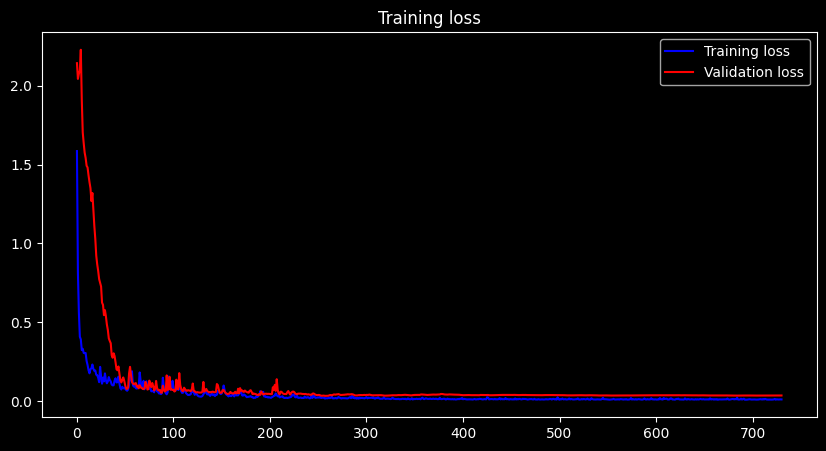

In [51]:
def plot_history(history):
    
    """
    history - create from model.fit
        
    """
    
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    f1_sc = history.history['f1']
    loss = history.history['loss']
    val_f1 = history.history['val_f1']
    val_loss = history.history['val_loss']

    epochs = range(len(f1_sc))

    #plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_f1, 'r', label='Validation acc')
    plt.plot(epochs, f1_sc, 'b', label='Training f1_score')
    plt.title('Training f1_score')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()

plot_history(history)

### Predict

In [26]:
# Загружаем веса с лучшим результатом и сохраняем на диске
model.load_weights(PATH_BEST_MODEL+'best_model.hdf5')
model.save_weights(PATH_BEST_MODEL+'best_weights.hdf5')
model.save(PATH_BEST_MODEL+'best_model_saved.hdf5')

In [27]:
# model.load_weights(PATH_BEST_MODEL+'best_model.hdf5')
y_pred_nn = model.predict(X_test_nn).argmax(axis=-1)

print(y_pred_nn.shape)
y_pred_nn

2/2 [==============================] - 0s 49ms/step
(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [28]:
y_pred = np.concatenate([arr for arr in y_pred_nn])

print(y_pred.shape)
y_pred

(5400,)


array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [29]:
# Сохраняем результат предсказания модели в отдельный файл
y_test = pd.read_csv(os.path.join(PATH, './sample_submission.csv'))
y_test['class'] = y_pred
y_test.to_csv(PATH_BEST_MODEL+'y_test_4lstm.csv', index=False)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
...,...,...
5396,376-96,4
5397,376-97,4
5398,376-98,4
5399,376-99,4


In [30]:
y_test['class'].value_counts()

0    3161
6     306
5     293
1     282
4     281
2     275
3     274
8     268
7     260
Name: class, dtype: int64